**Classification: Breast Cancer Detection**

Annalisa Donat, Data Scientist <br> Connect with me on [LinkedIn](https://www.linkedin.com/in/annalisa-donat-20476a104)

# Table of Contents

**Breast_Cancer_Detection**

1. [Set-Up](#Set-Up)
    1. Import Libraries
    2. Visualization and Summary Functions
        1. Variable Relationships
        2. Decomposition
        3. Hyperparameter Performance
        4. Learning Curves
        5. Model Comparison
2. [Data Exploration](#Data_Exploration)
    1. Load the Breast Cancer Dataset
    2. Create Training and Test Sets
    3. Explore Training Set
3. [Analysis: Model Evaluation and Hyperparameter Tuning](#Analysis)
    1. [Principal Component Analysis](#Principal_Component_Analysis)
    2. [Decision Tree](#Decision_Tree)
    3. [Gaussian Naive Bayes](#Gaussian_Naive_Bayes)
    4. [K Nearest Neighbors](#K_Nearest_Neighbors)
    5. [Logistic Regression](#Logistic_Regression)
    6. [Support Vector Machine](#Support_Vector_Machine)
4. [Compare Models](#Compare_Models)
    1. Learning Curves
    2. Get Train Set Predictions
    3. Adjust KNN Predictions
    4. Confusion Matrices
    5. Performance Metrics
5. [Ensemble Predictions](#Ensemble_Predictions)
    1. Examine Relationship Between Errors
    2. Implement Voting on Training Set
6. [Performance on Test Set](#Test_Set_Performance)
    1. Get Test Set Predictions
    2. Implement Voting on Test Set
    3. Confusion Matrices
    4. Performance Metrics




# Set-Up

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from sklearn.model_selection import train_test_split, learning_curve,\
    validation_curve, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, \
    recall_score, f1_score, make_scorer, accuracy_score

## Visualization and Summary Functions

These functions will make visualizing data and performance easier. **One does not need to review these functions in order to understand the analysis.** [Skip to Data Exploration](#Data_Exploration)

### Variable Relationships

In [2]:
def custom_pair_plot(df, var_list, class_var, scatter_alpha=0.4):
    """ Plot pairwise relationships in a dataset. Similar to seaborn's 
    pairplot function.

    This function will create a grid of Axes such that each variable in 
    var_list will be shared in the y-axis across a single row and in the 
    x-axis across a single column. These axes will each consist of a 
    scatterplot color-coded by class_var.

    The diagonal Axes are treated differently, drawing a plot to show the 
    univariate distribution of the data for the variable in that column. 
    These axes will each show the histograms of the distribution of their 
    respective variable for each value of class_var.

    Parameters
    ------------
    df : pandas DataFrame
    var_list : list[str]
        the variables that should be compared.
        - each item in var_list is a the name of a column in df that contains
          numerical (and preferably continuous) values.
        - does not contain class_var
    class_var : str
        the variable to use for color coding
        - the name of a column in df that contains discrete values.
    scatter_alpha : float or int
        the opacity of each point on a scatter plot.
        - Should be lower for larger datasets in order to show density.
        - 0 < scatter_alpha <= 1

    Returns
    ------------
    None
    """
    num_vars = len(var_list)
    
    fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, 
                             figsize=(num_vars*2, num_vars*2))
    
    # plot data:
    def loop_through_graphs(df_subset, plotting_color):
        for j in range(num_vars):
            for i in range(num_vars):
                if i==j:
                    all_class_min = min(df[var_list[i]])
                    all_class_max = max(df[var_list[i]])
                    bin_width = (all_class_max-all_class_min)/20 
                    axes[j][i].hist(
                        x=df_subset[var_list[i]], 
                        bins=np.arange(all_class_min, 
                                       all_class_max + bin_width, bin_width),
                        color=plotting_color, alpha=0.75)
                else:
                    axes[j][i].scatter(
                        x=df_subset[var_list[i]], y=df_subset[var_list[j]], 
                        color=plotting_color, s=2, alpha=scatter_alpha)
                # formatting: remove tickmark labels
                axes[j][i].set_xticklabels([])
                axes[j][i].set_yticklabels([])
                

    neg_df = df[df[class_var]==0].copy()
    pos_df = df[df[class_var]==1].copy()
        
    loop_through_graphs(neg_df, "blue") 
    loop_through_graphs(pos_df, "red") 
    
    # formatting: label x-axis of bottom row
    for k in range(num_vars):
        label_text = var_list[k].replace(" ", "\n")
        axes[num_vars-1][k].set_xlabel(label_text)
        axes[k][0].set_ylabel(label_text, rotation=0, ha="right", va="center")


### Decomposition

In [3]:
def plot_explained_variance(decomposer, num_features, 
                            decomposer_name=None, x_ax_label=None):
    """Plots variance explained by pca or lda component.
    Parameters
    ------------
    decomposer : PCA or LinearDiscriminantAnalysis
        must already be fitted
    num_features : int
        number of features in dataset used to fit decomposer
    decomposer_name : str
        ex. "PCA", "LDA"
    x_ax_label : str
        ex. "Principal Component Index", "Discriminant Index"
    
    Returns
    ------------
    None
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    variance_ratios = decomposer.explained_variance_ratio_
    padding_zeros = np.zeros(num_features - variance_ratios.shape[0])
    variance_ratios = np.hstack((variance_ratios, padding_zeros))
    ax.bar(range(1, num_features + 1), 
           variance_ratios, 
           alpha=0.8, align="center",
           label="individual explained variance")
    ax.step(range(1, num_features + 1), 
            variance_ratios.cumsum(), where="mid",
            label="cumulative explained variance", linewidth=3)
    ax.set_ylabel("Explained Variance Ratio")
    ax.set_xticks(np.arange(1, num_features + 1, 1))
    if x_ax_label:
        ax.set_xlabel(x_ax_label)
    else:
        ax.set_xlabel("Component Index")
    if decomposer_name:
        title = decomposer_name + ": Variance Explained"
    else:
        title = "Variance Explained"
    ax.axhline(y=1, color="black", linestyle="--")
    ax.set_title(title)
    ax.legend(loc="right")
    plt.tight_layout()
    plt.show()

### Hyperparameter Performance

In [4]:
def summarize_gs(gs):
    """Prints best test (validation) score of a fitted GridSearchCV object
    Parameters
    ------------
    gs : fitted GridSearchCV object
    
    Returns
    -------
    None
    """
    print("Best Parameters:", gs.best_params_)
    gs_std_test_score = gs.cv_results_["std_test_score"][gs.best_index_]
    print("Best Score: %.3f +/- %.3f" % (gs.best_score_, gs_std_test_score))

In [5]:
def plot_validation_curves(estimator, param_name, param_vals,
                           X_vals, y_vals, ax,
                           scoring_method="accuracy", cv_val=10, 
                           constant_params_dict=None):
    """plots the validation curves for estimator and param_name hyperparameter
    Parameters
    ------------
    estimator : classifier object
    param_name : str
        name of the hyperparameter to tune
        if estimator is a pipeline:
            "stepname__parameter_name"
        if estimator is not pipeline:
            "parameter_name"
    param_vals : array
        potential values of hyperparameter for validation_curve to test
        plotted on x-axis
    X_train : array
    y_train : array
    ax : matplotlib axis
    title : str
    cv : int
        number of folds
    scoring_method : str
        ex. "recall"
        should be all lowercase
    
    Returns
    ------------
    validation_curve_graph : graph on matplotlib axis
    """
    if constant_params_dict:
        estimator = estimator.set_params(**constant_params_dict)
    train_scores, test_scores = validation_curve(
        estimator=estimator, X=X_vals, y=y_vals, param_name=param_name, 
        param_range=param_vals, cv=cv_val, scoring=scoring_method)
    
    train_means_by_param_val = np.mean(train_scores, axis=1)
    train_stds_by_param_val = np.std(train_scores, axis=1)
    test_means_by_param_val = np.mean(test_scores, axis=1)
    test_stds_by_param_val = np.std(test_scores, axis=1)
    
    validation_curve_graph = ax.set_xlabel(param_name)
    ax.set_ylabel(scoring_method.capitalize())
    ax.set_xticks(param_vals)
        
    my_ax.plot(
        param_vals, train_means_by_param_val, 
        color="magenta", marker="o", markersize=5, 
        label="training " + scoring_method)

    ax.fill_between(
        param_vals, 
        train_means_by_param_val + train_stds_by_param_val,
        train_means_by_param_val - train_stds_by_param_val, 
        alpha=0.15, color="magenta")

    ax.plot(
        param_vals, test_means_by_param_val, 
        color="violet", linestyle="--", 
        marker="s", markersize=5, 
        label="validation " + scoring_method)

    ax.fill_between(
        param_vals, 
        test_means_by_param_val + test_stds_by_param_val,
        test_means_by_param_val - test_stds_by_param_val, 
        alpha=0.15, color="violet")

    ax.legend(loc="lower right")
    return validation_curve_graph

In [6]:
def get_scores_in_df(gs_search_results):
    """Creates a dataframe from gs_search_results
    Parameters
    ------------
    gs_search_results : GridSearchCV.cv_results_
    
    Returns
    ------------
    scores_df : pandas DataFrame
    """
    score_keys = [k for k in gs_search_results.keys() 
                  if ("_test_score" in k) and ("split" in k)]
    scores_dict = {k: gs_search_results[k] for k in score_keys}
    
    param_list = [k for param_combo in gs_search_results["params"] 
                  for k in param_combo.keys()]
    param_list = list(set(param_list))
    
    for k in param_list:
        scores_dict[k] = [param_combo.get(k) 
                          for param_combo in gs_search_results["params"]]
    scores_df = pd.DataFrame.from_dict(scores_dict)
    return scores_df

In [7]:
def melt_scores(df, param_names=[]):
    """Melts score columns for each GridSearchCV split into single score column
    
    Parameters
    ------------
    df : pandas DataFrame
        Output of get_scores_in_df
        Example:
        |param 1|param 2|split0_test_score|split1_test_score|
        |-------|-------|-----------------|-----------------|
        |A      |B      |.6               |.7               |
        |A      |C      |.5               |.8               |
        
    param_names: list([str])
        List of all columns in df that represent hyperparamters
        
    Returns
    ------------
    scores_df : pandas DataFrame
    Example:
        |param 1|param 2|Score|
        |-------|-------|-----|
        |A      |B      |.6   |
        |A      |B      |.7   |
        |A      |C      |.5   |
        |A      |C      |.8   |
    """
    score_vars = [col_name for col_name in list(df) 
                  if ("split" in col_name) and ("score" in col_name)]
    melted_df = pd.melt(df, id_vars=param_names, value_vars=score_vars)
    return melted_df

In [9]:
pink_color_palette = sns.diverging_palette(h_neg=335, h_pos=335, s=89, l=70, 
                                           sep=1, n=9)

In [10]:
def graph_hyperparameter_scores(
        scores_df, gs, x_var, hue_var=None, graph_title="", 
        fig_width=12, fig_height=5, score_x_coord=.5, score_y_coord_adj=0,
        txt_font_size=12, param_x_coord=0.7, param_y_coord=0.1, 
        y_lower_lim=0, y_upper_lim=1.05):
    """Graphs accuracy score by hyperparameter
    Parameters
    ------------
    scores_df: Pandas Dataframe
        Output of melt_scores
    gs : fitted GridSearchCV object
    x_var : str
        - Name of a hyperparameter tuned with gs and name of column in scores_df
        - If hue_var is not None hyperparameter combinations will be grouped by 
          x_var along the x-axis. 
    hue_var : str
        - If gs only had 1 hyperparameter, then None.
        - Else, name of a hyperparameter tuned with gs and the name of a 
          column in scores_df
        - Hyperparameter combinations with the same hue_var value will be 
          displayed in the same color.
    graph_title : str
    fig_width : int or float
    fig_height : int or float
    score_x_coord: int or float
        - Horizontal position on graph of label of best-score line
    score_y_coord_adj: int or float
        - Adjustment of vertical position on graph of best-score line 
        - Vertical position of label is first determined by y-value of 
          best-score line
    txt_font_size : int
    param_x_coord : int or float
        - Horizontal position on graph of label of best-parameters text
    param_y_coord : int or float
        - Vertical position on graph of label of best-parameters text
    y_lower_lim : int or float
        - The lower limit for the y-axis
    y_upper_lim : int or float
        - The upper limit for the y-axis
    Returns
    ------------
    None
    """
    # Set up graph:
    fig, my_ax = plt.subplots(figsize=(fig_width, fig_height))
    kw_catplot = {"x": x_var, "y": "value",  "ci": "sd", "data": scores_df,
                  "palette": pink_color_palette, "legend": False, 
                  "errwidth": 1, "kind": "bar", "ax": my_ax}
    if hue_var:
        kw_catplot["hue"] = hue_var
    sns.catplot(**kw_catplot)
    
    # Best score:
    my_ax.axhline(y=gs.best_score_, linestyle="--", color="black")
    score_label = "Best Score: %.3f" % gs.best_score_
    my_ax.text(score_x_coord, round(gs.best_score_, 2) + .03 + score_y_coord_adj, 
               score_label)
    
    # Best parameters:
    param_info = str(gs.best_params_).replace(", ", "\n")[1:-1]
    param_info = "Best Parameters:\n" + param_info
    props = dict(boxstyle="square", facecolor="white", alpha=0.8)
    my_ax.text(param_x_coord, param_y_coord, param_info, 
               transform=my_ax.transAxes, fontsize=txt_font_size,
               verticalalignment="bottom", bbox=props)
    
    # Legend:
    if hue_var:
        my_ax.legend_.remove()
        my_ax.legend(bbox_to_anchor=(1.05, 0.7), loc=2, 
                     borderaxespad=0., title=hue_var)
    
    # Formatting:
    my_ax.set_ylim(y_lower_lim, y_upper_lim)
    my_ax.set_ylabel("Recall Score")
    my_ax.set_title(graph_title)
    
    plt.close()

### Learning Curves

In [11]:
def plot_learning_curves(estimator_var, X_train, y_train, ax, title="", 
                         scoring_method="accuracy"):
    """plots the learning curves for estimator_var
    Parameters
    ------------
    estimator_var : classifier object
    X_train : array
    y_train : array
    ax : matplotlib axis
    title : str
    scoring_method : str
        ex. "recall"
        - should be all lowercase
    
    Returns
    ------------
    learning_curve_graph : graph on matplotlib axis
    """
    train_sizes, train_scores_by_size, test_scores_by_size = learning_curve(
        estimator=estimator_var, X=X_train, y=y_train, scoring=scoring_method,
        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

    train_means = np.mean(train_scores_by_size, axis=1)
    train_stds = np.std(train_scores_by_size, axis=1)
    test_means = np.mean(test_scores_by_size, axis=1)
    test_stds = np.std(test_scores_by_size, axis=1)

    learning_curve_graph = ax.plot(
        train_sizes, train_means, color="magenta", marker="o",
        markersize=5, label="training " + scoring_method)

    ax.fill_between(
        train_sizes, train_means + train_stds, train_means - train_stds,
        alpha=0.15, color="magenta")

    ax.plot(train_sizes, test_means, 
            color="violet", linestyle="--",
            marker="s", markersize=5, label="validation " + scoring_method)

    ax.fill_between(
        train_sizes, test_means + test_stds, test_means - test_stds,
        alpha=0.15, color="violet")

    ax.set_title(title)
    ax.set_xlabel("Size of Training Sets")
    ax.set_ylabel(scoring_method.capitalize())
    ax.legend(loc="lower right")
    ax.set_ylim(0, 1.02)
    return learning_curve_graph

In [12]:
def plot_all_learning_curves(name_estimator_dict, X_train, y_train, 
                             num_rows, num_cols, scoring_method="accuracy"):
    """Plots the learning curves for for each estimator in name_estimator_dict
    Parameters
    ------------
    name_estimator_dict : dict{str: classifier object}
        -  {classifier names/label: classifier object}
    X_train : array
    y_train : array
    num_rows : int
        - number of rows of subplots (assuming enough estimators provided)
    num_cols : int
        - number of columns of subplots
    scoring_method : str
        - scoring method to apply
        - ex. "recall" or "precision"
        - should be all lowercase
        
    Returns
    ------------
    None 
    """
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, 
                            figsize=(num_cols*4, num_rows*3))
    estimator_names = [k for k in name_estimator_dict.keys()]
    estimator_objs = [v for v in name_estimator_dict.values()]
    
    for i, ax in enumerate(fig.axes):
        try:
            plot_learning_curves(
                estimator_objs[i], X_train, y_train, ax, 
                title=estimator_names[i], scoring_method=scoring_method)
        except IndexError:
            ax.remove()
    fig.suptitle("Learning Curves", y=1.05, fontsize=14)
    plt.tight_layout()

### Model Comparison

In [13]:
def get_training_set_predictions_df(name_model_gsbp_list, X_vals, y_vals):
    """Returns dataframe of classifier predictions for training set
    Parameters
    ------------
    name_model_gsbp_list : list[(str, classifier, GridSearchCV.best_params)]
        - Example:
            [("Classifier A", pipe_clf_a, gs1_clf_a.best_params), 
             ("Classifier B", pipe_clf_b, gs2_clf_b.best_params)...]
    X_vals : array
        - X values for training set
    y_vals : array
        - y (target) values for training set
        
    Returns
    ------------
    predictions_df : pandas dataframe
        - Example:
            |Target|Classifier A|Classifier B|Classifier C|
            |      | Prediction | Prediction | Prediction |
            |------|------------|------------|------------|
            |   0  |      1     |     0      |     0      |
            |   1  |      1     |     1      |     1      |
            |   1  |      1     |     1      |     0      |
            |   0  |      0     |     0      |     0      |
    """
    predictions_dict = {"target": y_vals}
    for clsf_tuple in name_model_gsbp_list:
        model = clsf_tuple[1]
        model = model.set_params(**clsf_tuple[2])
        model.fit(X_vals, y_vals)
        model_y_pred = model.predict(X_vals)
        predictions_dict[clsf_tuple[0]] = model_y_pred
    predictions_df = pd.DataFrame.from_dict(predictions_dict)
    return predictions_df

In [14]:
def get_test_set_predictions_df(name_model_gsbp_list, X_train, y_train, 
                                X_test, y_test):
    """Returns dataframe of classifier predictions for test set
    Parameters
    ------------
    name_model_gsbp_list : list[(str, classifier, GridSearchCV.best_params)]
        - Example:
            [("Classifier A", pipe_clf_a, gs1_clf_a.best_params), 
             ("Classifier B", pipe_clf_b, gs2_clf_b.best_params)...]
    X_train : array
    y_train : array
    X_test : array
    y_test : array
        
    Returns
    ------------
    predictions_df : pandas dataframe
        - Example:
            |Target|Classifier A|Classifier B|Classifier C|
            |      | Prediction | Prediction | Prediction |
            |------|------------|------------|------------|
            |   0  |      1     |     0      |     0      |
            |   1  |      1     |     1      |     1      |
            |   1  |      1     |     1      |     0      |
            |   0  |      0     |     0      |     0      |
    """
    predictions_dict = {"target": y_test}
    for clsf_tuple in name_model_gsbp_list:
        model = clsf_tuple[1]
        model = model.set_params(**clsf_tuple[2])
        model.fit(X_train, y_train)
        model_y_pred = model.predict(X_test)
        predictions_dict[clsf_tuple[0]] = model_y_pred
    predictions_df = pd.DataFrame.from_dict(predictions_dict)
    return predictions_df

In [15]:
N = 256
pink_vals = np.ones((N, 4))
pink_vals[:, 0] = np.linspace(255/256, 1, N)
pink_vals[:, 1] = np.linspace(107/256, 1, N)
pink_vals[:, 2] = np.linspace(245/256, 1, N)
awareness_pink_cmp = ListedColormap(pink_vals)


In [16]:
def show_confusion_matrices(prediction_df, cols=None, title_info=None):
    """Plots row of axes, each a confusion matrix for a column in prediction_df
    Parameters
    ------------
    prediction_df : pandas DataFrame
    cols : list[str]
        - list of variables for which to show a confusion matrix
        - each item in cols is the name of a column in prediction_df
    title_info : str
        label to add to title
            - ex. "K Nearest Neighbors"
    Returns
    ------------
    None
    """
    if not cols:
        cols = [col for col in list(prediction_df) if col != "target"]

    confusion_matrices = [confusion_matrix(
        y_true=prediction_df["target"], y_pred=prediction_df[col])
                          for col in cols]

    fig, axes = plt.subplots(ncols=len(cols), 
                             figsize=(len(cols)*2.5, 3.5))
        
    for k, ax in enumerate(fig.axes):
        confmat = confusion_matrices[k]
        ax.matshow(confmat, cmap=awareness_pink_cmp, alpha=0.3)
        for i in range(confmat.shape[0]):
            for j in range(confmat.shape[1]):
                ax.text(x=j, y=i, s=confmat[i, j], 
                        va="center", ha="center", fontsize=14)
        ax.xaxis.set_ticks_position("bottom")
        ax.set_xlabel("Predicted label")
        ax.set_title(cols[k])
    
    axes[0].set_ylabel("True label")
    if title_info:
        #title = "Confusion Matrices – " + title_info
        title = "Confusion Matrices {0} ".format(u"\u2014") + title_info
    else:
        title = "Confusion Matrices"
    fig.suptitle(title, fontsize=14)
    plt.subplots_adjust(wspace=.4)
        
    plt.show()


In [17]:
def get_performance_metrics_df(df, cols=None):
    """Returns dataframe of performance metric scores for each classifier.
    Parameters
    ------------
    df : pandas dataframe
        - contains predictions. columns are target and classifiers.
        - output of get_training_set_predictions_df 
          or get_test_set_predictions_df
    cols : list[str]
        - names of each classifier. each item is name of column in df.
    
    Returns
    ------------
    performance_df : pandas dataframe
        - columns = ["Accuracy", "Precision", "Recall", "F1 Score"]
        - indexed by classifier name (cols)
    """
    target = df["target"]
    if not cols:
        cols = [c for c in list(df) if c!="target"]
    performance_dict = {}
    for col in cols:
        pred = df[col]
        perf_metrics = np.array(
            [recall_score(target, pred), accuracy_score(target, pred), 
             precision_score(target, pred), f1_score(target, pred)])
        performance_dict[col] = perf_metrics
    performance_df = pd.DataFrame.from_dict(performance_dict)
    performance_df = performance_df.T
    performance_col_names = ["Recall", "Accuracy", "Precision", "F1 Score"]
    performance_df = performance_df.rename(
        columns={k: v for k, v in enumerate(performance_col_names)})
    performance_df.index.name = "Classifier"
    performance_df = performance_df.sort_values("Recall", ascending=False)
    return performance_df

<hr>

<a id="Data_Exploration"></a>

# Data Exploration

## Load the Breast Cancer Dataset

In [18]:
wbc_df = pd.read_csv("../breast_cancer_wisconsin_data_means.csv")

In [19]:
wbc_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [20]:
print("Dataset contains %d rows" % wbc_df.shape[0])
print("Dataset contains %d columns" % wbc_df.shape[1])

Dataset contains 569 rows
Dataset contains 12 columns


In [21]:
wbc_df = wbc_df.rename(
    columns={c: c.replace("_mean", "") for c in list(wbc_df)})

In [22]:
wbc_df.head()

,id,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,fractal_dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [23]:
wbc_df.tail()

,id,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,fractal_dimension
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884


In [25]:
wbc_df.dtypes

id                     int64
diagnosis             object
radius               float64
texture              float64
perimeter            float64
area                 float64
smoothness           float64
compactness          float64
concavity            float64
concave points       float64
symmetry             float64
fractal_dimension    float64
dtype: object

In [26]:
wbc_df["id"] = wbc_df["id"].astype(str)

In [27]:
wbc_df["diagnosis"] = wbc_df["diagnosis"].map({"B": 0, "M": 1})

In [28]:
wbc_df["id"].nunique()

569

In [29]:
wbc_df.isnull().sum()

id                   0
diagnosis            0
radius               0
texture              0
perimeter            0
area                 0
smoothness           0
compactness          0
concavity            0
concave points       0
symmetry             0
fractal_dimension    0
dtype: int64

In [30]:
wbc_df["diagnosis"].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

## Create Training and Test Sets

Creating a test set allows us to evaluate the variance of our model. Variance is the extent to which our observations can be generalized to unseen data.

In [31]:
predictor_names = [c for c in list(wbc_df) if c not in ["id", "diagnosis"]]

In [32]:
wbc_y = wbc_df["diagnosis"].values

In [33]:
wbc_train_df, wbc_test_df = train_test_split(
    wbc_df, test_size=0.20, stratify=wbc_y, random_state=1)

In [34]:
wbc_X_train = wbc_train_df[predictor_names].values
wbc_y_train = wbc_train_df["diagnosis"].values
wbc_X_test = wbc_test_df[predictor_names].values
wbc_y_test = wbc_test_df["diagnosis"].values

## Explore Training Set

In [35]:
print("Observations in Training Set:", wbc_train_df.shape[0])

Observations in Training Set: 455


In [36]:
wbc_train_df["diagnosis"].value_counts()

0    285
1    170
Name: diagnosis, dtype: int64

Examine the relationships between the variables with scatter plots and histograms, color coded by class.

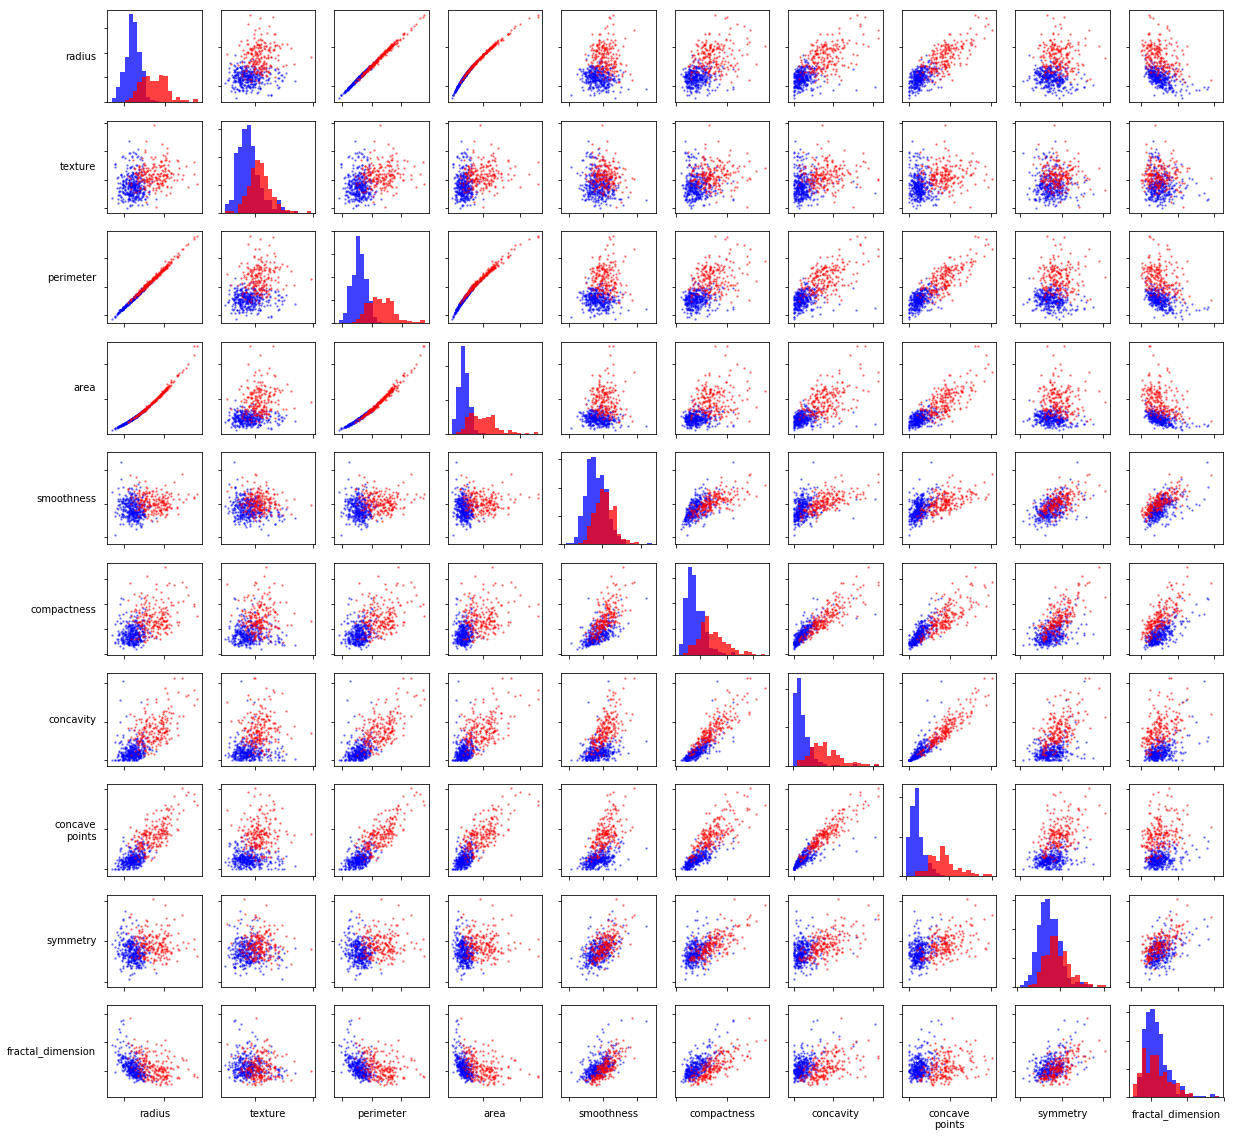

In [38]:
custom_pair_plot(wbc_df, predictor_names, class_var="diagnosis")

**Observations**

- For almost all variables, malignant (positive) tumors tend to have higher values than benign (negative) tumors. 
    - The exception is fractal_dimension, for which tumor class does not seem to impact distribution.
- All variables except fractal_dimension seem to be positively correlated.
    - In fact, there seems to be a direct relationship between area, perimeter, and radius.
    - These strong correlations mean that it is possible to reduce the dimensions of the dataset while retaining the vast majority of the information it contains. 
- All variables have a fairly normal within-class distribution.
    - The only exception is the distribution of concavity in the benign tumor class, which is skewed.
    - Normal distributions make it possible to run analyses such as the Linear Discriminant Analysis.

<hr>

**Examine the correlations between variables:**

In [39]:
wbc_df[predictor_names].corr().round(2)

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,fractal_dimension
radius,1.00,0.32,1.00,0.99,0.17,0.51,0.68,0.82,0.15,-0.31
texture,0.32,1.00,0.33,0.32,-0.02,0.24,0.30,0.29,0.07,-0.08
perimeter,1.00,0.33,1.00,0.99,0.21,0.56,0.72,0.85,0.18,-0.26
area,0.99,0.32,0.99,1.00,0.18,0.50,0.69,0.82,0.15,-0.28
smoothness,0.17,-0.02,0.21,0.18,1.00,0.66,0.52,0.55,0.56,0.58
compactness,0.51,0.24,0.56,0.50,0.66,1.00,0.88,0.83,0.60,0.57
concavity,0.68,0.30,0.72,0.69,0.52,0.88,1.00,0.92,0.50,0.34
concave points,0.82,0.29,0.85,0.82,0.55,0.83,0.92,1.00,0.46,0.17
symmetry,0.15,0.07,0.18,0.15,0.56,0.60,0.50,0.46,1.00,0.48
fractal_dimension,-0.31,-0.08,-0.26,-0.28,0.58,0.57,0.34,0.17,0.48,1.00


There is a high correlation amongst the predictor variables. Therefore, I will implement a principal component analysis to reduce dimensionality and prevent overfitting. 

<hr>

<a id="Analysis"></a>

# Analysis: Model Evaluation and Hyperparameter Tuning

Create the following models for classifying coffee as from Africa or North America based on taste test results:
- Logistic Regression
- Support Vector Machine
- Decision Tree
- K Nearest Neighbors
- Gaussian Naive Bayes

<br>
For each model, create one version with a pca step and one version without it. Use the version that performs best on the training set.


<hr>

<a id="Principal_Component_Analysis"></a>

## Principal Component Analysis

In [40]:
sc = StandardScaler()
pca = PCA()

In [41]:
wbc_X_train_std = sc.fit_transform(wbc_X_train)

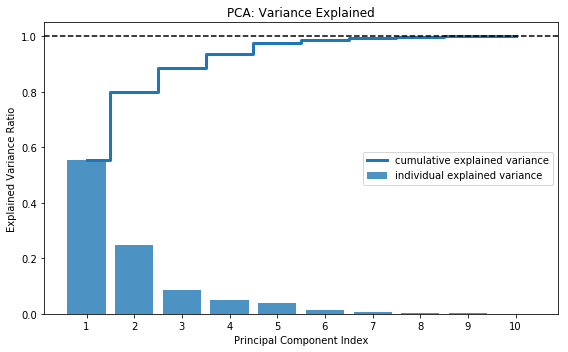

In [42]:
pca = pca.fit(wbc_X_train_std)
plot_explained_variance(pca, 10, "PCA", "Principal Component Index")

I hypothesize that including 6 or more principal components will lead to overfitting.

In [43]:
exponential_tens = np.array([10**i for i in range(-3, 4)])
one_to_ten = np.arange(1, 11, 1)

<hr>

<a id="Decision_Tree"></a>

## Decision Tree

### Define Pipelines 

In [44]:
dt = DecisionTreeClassifier(random_state=0)

In [45]:
pipe_dt = Pipeline([("dt", dt)])
pipe_dt_pca = Pipeline([("pca", pca), ("dt", dt)])

### Fit Pipelines to Best Hyperparameters

In [46]:
dt_hyperparameters = {"dt__max_depth": [1, 2, 3, 4, 5, 6, 7, None],
                      "dt__min_samples_split": [2, 5, 10, 20, 30], 
                      "dt__class_weight": ["balanced"]}
dt_pca_hyperparameters = {"pca__n_components": one_to_ten,
                          "dt__max_depth": [1, 2, 3, 4, 5, 6, 7, None],
                          "dt__min_samples_split": [2, 5, 10, 20, 30], 
                          "dt__class_weight": ["balanced"]}

In [47]:
gs_dt = GridSearchCV(
    estimator=pipe_dt, param_grid=dt_hyperparameters, 
    scoring="recall", return_train_score=True, cv=10, n_jobs=-1, iid=True)

gs_dt = gs_dt.fit(wbc_X_train, wbc_y_train)

summarize_gs(gs_dt)

Best Parameters: {'dt__class_weight': 'balanced', 'dt__max_depth': 5, 'dt__min_samples_split': 10}
Best Score: 0.941 +/- 0.059


In [48]:
gs_dt_pca = GridSearchCV(
    estimator=pipe_dt_pca, param_grid=dt_pca_hyperparameters, 
    scoring="recall", return_train_score=True, cv=10, n_jobs=-1, iid=True)

gs_dt_pca = gs_dt_pca.fit(wbc_X_train, wbc_y_train)

summarize_gs(gs_dt_pca)

Best Parameters: {'dt__class_weight': 'balanced', 'dt__max_depth': 4, 'dt__min_samples_split': 2, 'pca__n_components': 5}
Best Score: 0.912 +/- 0.071


Use the pipeline without a PCA step for predictions, as it has the highest mean score.

The model performs best when dt__min_samples_split = 10. However, only 2, 5, 10, 20, and 30 were evaluated as potential values for the number of minimum samples per split. To see if a value near 10 that was not tested (ex. 9, 11) yields better results, I checked the validation curve.

In [51]:
dt_validation_constants = {"dt__class_weight": "balanced", "dt__max_depth": 5}
min_samples_split_vals = np.arange(4, 22, 1)

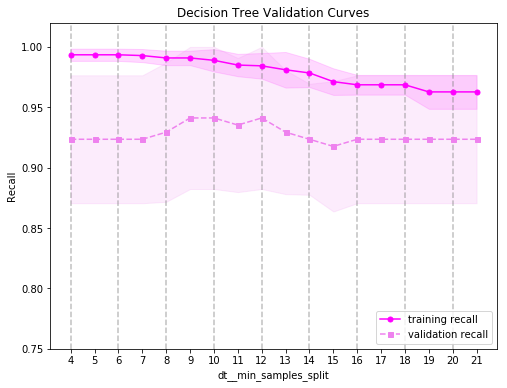

In [53]:
fig, my_ax = plt.subplots(figsize=(8, 6))
for i in range(4, 22, 2):
    my_ax.axvline(x=i, color="gray", linestyle="--", alpha=0.5)
plot_validation_curves(pipe_dt, "dt__min_samples_split", min_samples_split_vals,
                       wbc_X_train, wbc_y_train, my_ax, scoring_method="recall", 
                       constant_params_dict=dt_validation_constants)
my_ax.set_title("Decision Tree Validation Curves")
my_ax.set_ylim(.75, 1.02)
plt.show()

It appears that 10 is indeed a sweet spot for the minimum number of samples per split. The model performed equally well on the validation sets when this parameter was set to 9 and 12. As 10 is between the two, I will leave the dt__min_samples_split value at 10.

### Compare Hyperparameters

In [54]:
dt_scores = get_scores_in_df(gs_dt.cv_results_)
dt_scores = melt_scores(dt_scores, 
                        param_names=["dt__min_samples_split", "dt__max_depth"])


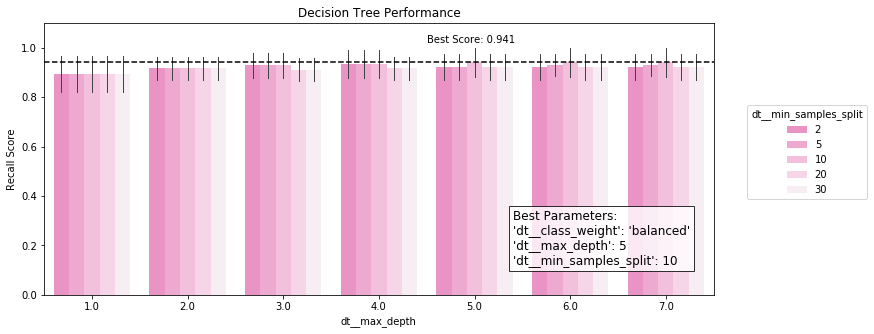

In [58]:
graph_hyperparameter_scores(dt_scores, gs_dt, "dt__max_depth",
                            hue_var="dt__min_samples_split", 
                            graph_title="Decision Tree Performance", 
                            score_x_coord=3.5, score_y_coord_adj=.05, 
                            y_upper_lim=1.1)

<hr>

<a id="Gaussian_Naive_Bayes"></a>

## Gaussian Naive Bayes

### Define Pipelines

In [59]:
gnb = GaussianNB()

In [60]:
pipe_gnb = Pipeline([("sc", sc), ("gnb", gnb)])
pipe_gnb_pca = Pipeline([("sc", sc), ("pca", pca), ("gnb", gnb)])

### Fit Pipelines to Best Hyperparameters

As pipe_gnb does not have any hyperparameters, use cross_val_score to measure it's performance.

In [61]:
pipe_gnb_scores = cross_val_score(pipe_gnb, wbc_X_train, wbc_y_train, 
                                  cv=10, scoring="recall")
print("Score: %.3f +/- %.3f" % (pipe_gnb_scores.mean(), pipe_gnb_scores.std()))

Score: 0.859 +/- 0.084


In [62]:
gnb_pca_hyperparameters = {"pca__n_components": one_to_ten}

In [63]:
gs_gnb_pca = GridSearchCV(
    estimator=pipe_gnb_pca, param_grid=gnb_pca_hyperparameters, 
    scoring="recall", return_train_score=True, cv=10, n_jobs=-1, iid=True)

gs_gnb_pca = gs_gnb_pca.fit(wbc_X_train, wbc_y_train)

summarize_gs(gs_gnb_pca)

Best Parameters: {'pca__n_components': 5}
Best Score: 0.876 +/- 0.103


Use the pipeline with the PCA step for predictions, as it had a higher mean score.

### Compare Hyperparameters

In [64]:
gnb_scores = get_scores_in_df(gs_gnb_pca.cv_results_)

In [65]:
gnb_scores = melt_scores(gnb_scores, param_names=["pca__n_components"])

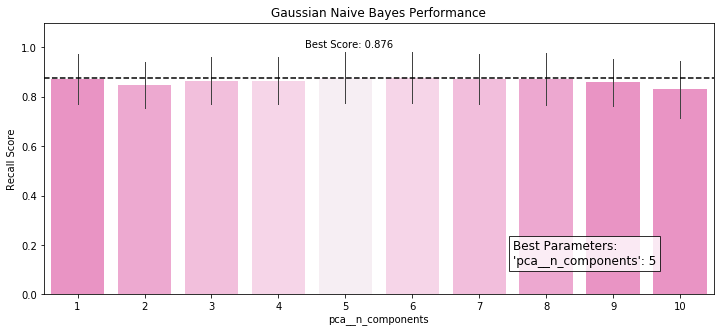

In [68]:
graph_hyperparameter_scores(gnb_scores, gs_gnb_pca, "pca__n_components", 
                            graph_title="Gaussian Naive Bayes Performance", 
                            score_x_coord=3.4, score_y_coord_adj=.09, 
                            y_upper_lim=1.1)

<hr>

<a id="K_Nearest_Neighbors"></a>

## K Nearest Neighbors

### Define Pipelines

In [69]:
knn = KNeighborsClassifier()

In [70]:
pipe_knn = Pipeline([("sc", sc), ("knn", knn)])
pipe_knn_pca = Pipeline([("sc", sc), ("pca", pca), ("knn", knn)])

### Fit Pipelines to Best Hyperparameters

In [71]:
knn_hyperparameters = {"knn__n_neighbors": [1, 3, 5, 7, 9, 11], 
                       "knn__weights": ["uniform", "distance"]}
knn_pca_hyperparameters = {"pca__n_components": one_to_ten, 
                           "knn__n_neighbors": [1, 3, 5, 7, 9, 11], 
                           "knn__weights": ["uniform", "distance"]}

In [72]:
gs_knn = GridSearchCV(
    estimator=pipe_knn, param_grid=knn_hyperparameters, 
    scoring="recall", return_train_score=True, cv=10, n_jobs=-1, iid=True)

gs_knn = gs_knn.fit(wbc_X_train, wbc_y_train)

summarize_gs(gs_knn)

Best Parameters: {'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
Best Score: 0.923 +/- 0.070


In [73]:
gs_knn_pca = GridSearchCV(
    estimator=pipe_knn_pca, param_grid=knn_pca_hyperparameters, 
    scoring="recall", return_train_score=True, cv=10, n_jobs=-1, iid=True)

gs_knn_pca = gs_knn_pca.fit(wbc_X_train, wbc_y_train)

summarize_gs(gs_knn_pca)

Best Parameters: {'knn__n_neighbors': 5, 'knn__weights': 'uniform', 'pca__n_components': 5}
Best Score: 0.929 +/- 0.069


Use the pipeline with the PCA step for predictions as it had a higher mean score.

### Compare Hyperparameters

In [74]:
knn_scores = get_scores_in_df(gs_knn_pca.cv_results_)
knn_scores = knn_scores[knn_scores["knn__weights"]=="uniform"].copy()
knn_scores = melt_scores(
    knn_scores, param_names=["knn__n_neighbors", "pca__n_components"])

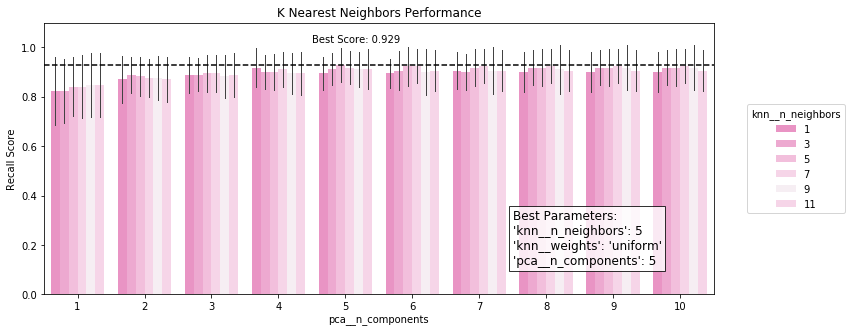

In [76]:
graph_hyperparameter_scores(knn_scores, gs_knn_pca, "pca__n_components", 
                            hue_var="knn__n_neighbors", 
                            graph_title="K Nearest Neighbors Performance", 
                            y_upper_lim=1.1,
                            score_x_coord=3.5, score_y_coord_adj=0.06)

<hr>

<a id="Logistic_Regression"></a>

## Logistic Regression

### Define Pipelines

In [77]:
lr = LogisticRegression(penalty="l2", solver="liblinear", random_state=1)

In [78]:
pipe_lr = Pipeline([("sc", sc), ("lr", lr)])
pipe_lr_pca = Pipeline([("sc", sc), ("pca", pca), ("lr", lr)])

### Fit Pipelines to Best Hyperparameters

In [79]:
lr_hyperparameters = {"lr__C": exponential_tens, "lr__class_weight": ["balanced"]}
lr_pca_hyperparameters = {"pca__n_components": one_to_ten, 
                          "lr__C": exponential_tens, "lr__class_weight": ["balanced"]}

In [80]:
gs_lr = GridSearchCV(
    estimator=pipe_lr, param_grid=lr_hyperparameters, scoring="recall", 
    return_train_score=True, cv=10, iid=True)

gs_lr = gs_lr.fit(wbc_X_train, wbc_y_train)

summarize_gs(gs_lr)

Best Parameters: {'lr__C': 1.0, 'lr__class_weight': 'balanced'}
Best Score: 0.918 +/- 0.075


In [81]:
gs_lr_pca = GridSearchCV(
    estimator=pipe_lr_pca, param_grid=lr_pca_hyperparameters, 
    scoring="recall", return_train_score=True, cv=10, iid=True)

gs_lr_pca = gs_lr_pca.fit(wbc_X_train, wbc_y_train)

summarize_gs(gs_lr_pca)

Best Parameters: {'lr__C': 10.0, 'lr__class_weight': 'balanced', 'pca__n_components': 5}
Best Score: 0.935 +/- 0.056


Use the pipeline with the PCA step, as it has the highest mean score.

### Compare Hyperparameters

In [82]:
lr_scores = get_scores_in_df(gs_lr_pca.cv_results_)
lr_scores = melt_scores(lr_scores, param_names=["lr__C", "pca__n_components"])

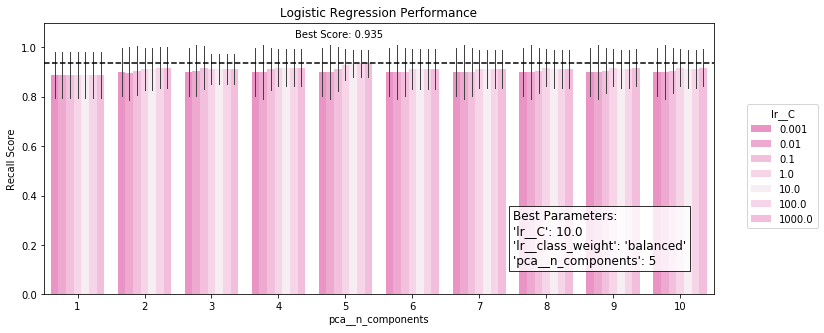

In [84]:
graph_hyperparameter_scores(lr_scores, gs_lr_pca, "pca__n_components", 
                            hue_var="lr__C", 
                            graph_title="Logistic Regression Performance", 
                            score_x_coord=3.25, score_y_coord_adj=.07, 
                            y_upper_lim=1.1)

<hr>

<a id="Support_Vector_Machine"></a>

## Support Vector Machine

### Define Pipelines

In [85]:
svc = SVC(random_state=1)

In [86]:
pipe_svc = Pipeline([("sc", sc), ("svc", svc)])
pipe_svc_pca = Pipeline([("sc", sc), ("pca", pca), ("svc", svc)])

### Fit Pipelines to Best Hyperparameters

In [87]:
svc_hyperparameters = {"svc__C": exponential_tens, 
                       "svc__kernel": ["linear"], 
                       "svc__class_weight": ["balanced"]}
svc_pca_hyperparameters = {"pca__n_components": one_to_ten, 
                           "svc__C": exponential_tens, 
                           "svc__kernel": ["linear"], 
                           "svc__class_weight": ["balanced"]}

In [88]:
gs_svc = GridSearchCV(
    estimator=pipe_svc, param_grid=svc_hyperparameters, scoring="recall", 
    return_train_score=True, cv=10, n_jobs=-1, iid=True)

gs_svc = gs_svc.fit(wbc_X_train, wbc_y_train)

summarize_gs(gs_svc)

Best Parameters: {'svc__C': 100.0, 'svc__class_weight': 'balanced', 'svc__kernel': 'linear'}
Best Score: 0.912 +/- 0.088


In [89]:
gs_svc_pca = GridSearchCV(
    estimator=pipe_svc_pca, param_grid=svc_pca_hyperparameters, 
    scoring="recall", return_train_score=True, cv=10, n_jobs=-1, iid=True)

gs_svc_pca = gs_svc_pca.fit(wbc_X_train, wbc_y_train)

summarize_gs(gs_svc_pca)

Best Parameters: {'pca__n_components': 2, 'svc__C': 10.0, 'svc__class_weight': 'balanced', 'svc__kernel': 'linear'}
Best Score: 0.929 +/- 0.078


Use the pipeline with the PCA step for predictions as it had a higher mean score.

### Compare Hyperparameters

In [90]:
svc_scores = get_scores_in_df(gs_svc_pca.cv_results_)

In [91]:
svc_scores = melt_scores(svc_scores, ["svc__C", "pca__n_components"])

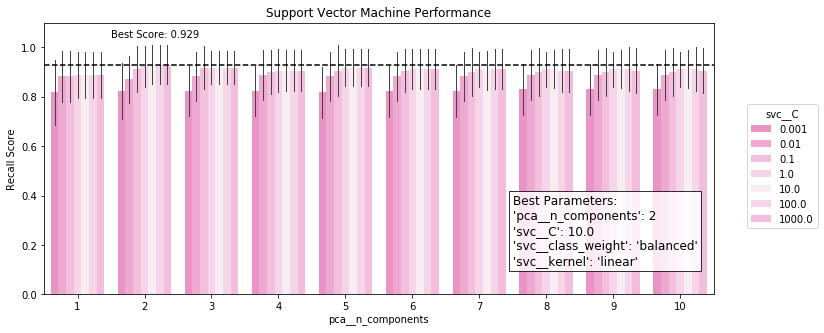

In [93]:
graph_hyperparameter_scores(svc_scores, gs_svc_pca, "pca__n_components", 
                            hue_var="svc__C", 
                            graph_title="Support Vector Machine Performance", 
                            score_y_coord_adj=.08, y_upper_lim=1.1)

<hr>

<a id="Compare_Models"></a>

# Compare Models

In [94]:
pipe_dt = pipe_dt.set_params(**gs_dt.best_params_)
pipe_gnb_pca = pipe_gnb_pca.set_params(**gs_gnb_pca.best_params_)
pipe_knn_pca = pipe_knn_pca.set_params(**gs_knn_pca.best_params_)
pipe_lr_pca = pipe_lr_pca.set_params(**gs_lr_pca.best_params_)
pipe_svc_pca = pipe_svc_pca.set_params(**gs_svc_pca.best_params_)

In [95]:
pipe_dt = pipe_dt.fit(wbc_X_train, wbc_y_train)
pipe_gnb_pca = pipe_gnb_pca.fit(wbc_X_train, wbc_y_train)
pipe_knn_pca = pipe_knn_pca.fit(wbc_X_train, wbc_y_train)
pipe_lr_pca = pipe_lr_pca.fit(wbc_X_train, wbc_y_train)
pipe_svc_pca = pipe_svc_pca.fit(wbc_X_train, wbc_y_train)

In [96]:
classifiers_list = [
    ("Decision Tree", pipe_dt, gs_dt.best_params_, False),
    ("Gaussian Naive Bayes", pipe_gnb_pca, gs_gnb_pca.best_params_, True),
    ("K Nearest Neighbors", pipe_knn_pca, gs_knn_pca.best_params_, True),
    ("Logistic Regression", pipe_lr_pca, gs_lr_pca.best_params_, True), 
    ("Support Vector Machine", pipe_svc_pca, gs_svc_pca.best_params_, False)]

In [97]:
classifiers_dict = {item[0]: item[1] for item in classifiers_list}

In [98]:
classifier_labels = [k for k in classifiers_dict.keys()]

## Learning Curves

Learning curves are helpful for predicting the benefits of collecting more data.

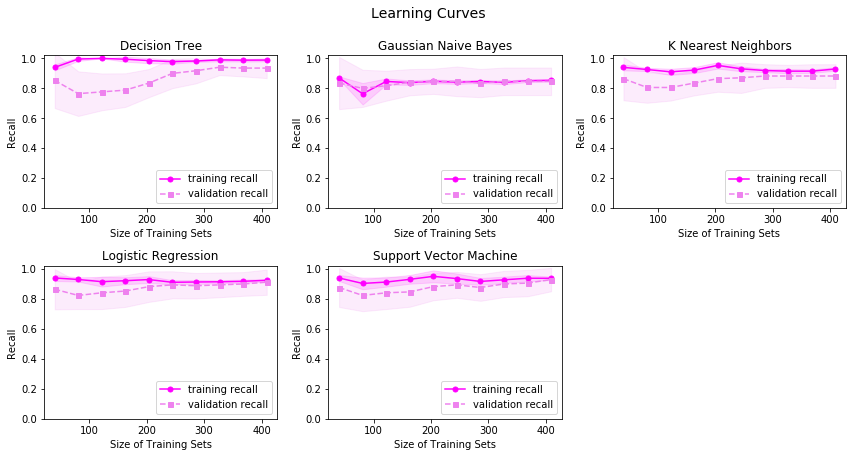

In [99]:
plot_all_learning_curves(classifiers_dict, wbc_X_train, wbc_y_train, 2, 3, 
                         scoring_method="recall")

These classifiers would be unlikely to dramatically improve validation recall if fitted on a larger training data set, as their training accuracy and validation accuracy curves have already converged.

## Get Train Set Predictions

In [100]:
train_predictions_df = get_training_set_predictions_df(
    classifiers_list, wbc_X_train, wbc_y_train)

In [101]:
train_predictions_df.head()

,target,Decision Tree,Gaussian Naive Bayes,K Nearest Neighbors,Logistic Regression,Support Vector Machine
0,0,0,0,0,0,0
1,0,0,0,1,1,1
2,0,0,0,0,0,0
3,0,1,0,1,1,1
4,0,0,0,0,0,0


## Adjust KNN Predictions

Once the K Nearest Neighbors Classifier has been fitted on the entire training set, each observation in the training set will be its own closest neighbor. This could inflate the accuracy of the K Nearest Neighbors Classifier, as at least one of the K Nearest Neighbors will always have the right class. For example, if k = 1, then the fitted K Nearest Neighbors Classifier will have 100% accuracy on the training set.

GridSearchCV showed that the best hyperparameters for this classifier are k = 5 and number of principal components = 6.

Currently, the class predicted by the K Nearest Neighbors Classifier for each observation in the training set, is the most common class among the observation's 1st (itself), 2nd, 3rd, 4th, and 5th nearest neighbors.

Get the six nearest neighbors of each observation in the sample:

In [102]:
pca = PCA(n_components=5)
wbc_X_train_pca = pca.fit_transform(wbc_X_train_std)
n_neighbors_ind = knn.kneighbors(wbc_X_train_pca[:, :5], 6, 
                                 return_distance=False)

In [103]:
n_neighbors_y_vals = wbc_y_train[n_neighbors_ind]

Get the most common class among the 2nd, 3rd, 4th, 5th, and 6th nearest neighbors:

In [104]:
knn_1to6_probs = n_neighbors_y_vals[:, 1:6].mean(axis=1)

In [105]:
knn_1to6_preds = np.where(knn_1to6_probs < 0.5, 0, 1)

In [107]:
train_predictions_df["K Nearest Neighbors V2"] = train_predictions_df.index.map(
    pd.Series(knn_1to6_preds))

## Confusion Matrices

<div style="text-align:center"><b>Example Confusion Matrix</b></div>

|.|Predicted Pos|Predicted Neg|
|------|-|-|
|Actual Pos|Num True Positives|Num False Negatives|
|Actual Neg|Num False Positives|Num True Negatives|

In [108]:
classifier_labels = classifier_labels + ["K Nearest Neighbors V2"]
classifier_labels = sorted(classifier_labels)

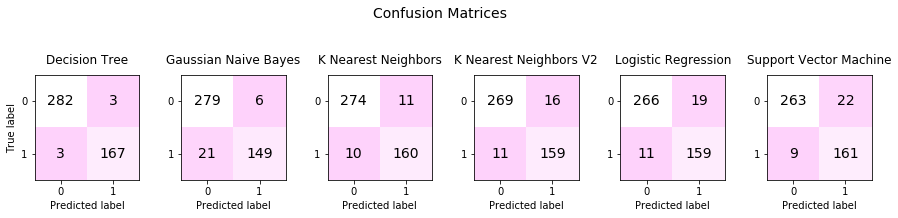

In [109]:
show_confusion_matrices(train_predictions_df, cols=classifier_labels)

## Performance Metrics

|<div align="left">Metric</div>|<div align="left">Formula</div>|<div align="left">Description</div>|
|------|-------|-----------|
|<div align="left">Accuracy</div>|$\frac{TP+TN}{Total}$|<div align="left">Pct of samples that were correctly classified</div>|
|<div align="left">Recall</div>|$\frac{TP}{TP+FN}$|<div align="left">Pct of positive samples that were correctly classified</div>|
|<div align="left">Precision</div>|$\frac{TP}{TP+FP}$|<div align="left">Pct of samples classified as positive that were actually positive</div>|
|<div align="left">F1 Score</div>|$2\frac{Pre \cdot Rec}{Pre+Rec}$|<div align="left">See formula</div>|

In [110]:
get_performance_metrics_df(train_predictions_df, 
                           cols=classifier_labels).round(3)

,Recall,Accuracy,Precision,F1 Score
Classifier,,,,
Decision Tree,0.982,0.987,0.982,0.982
Support Vector Machine,0.947,0.932,0.880,0.912
K Nearest Neighbors,0.941,0.954,0.936,0.938
K Nearest Neighbors V2,0.935,0.941,0.909,0.922
Logistic Regression,0.935,0.934,0.893,0.914
Gaussian Naive Bayes,0.876,0.941,0.961,0.917


The Decision Tree classifier has highest recall, while the Gaussian Naive Bayes classifiers has the lowest recall.

All classifiers have a recall score well over 0.5, meaning that ensemble voting will further increase recall if there is not a strong positive correlation between errors.

<hr>

<a id="Ensemble_Predictions"></a>

# Ensemble Predictions

In [111]:
classifier_labels = [cl for cl in classifier_labels 
                     if cl != "K Nearest Neighbors"]

## Examine Relationship Between Errors

### Error Correlation

In [112]:
errors_df = train_predictions_df.copy()
for col_name in classifier_labels:
    errors_df[col_name] = errors_df[col_name] - errors_df["target"]

In [113]:
errors_df[classifier_labels].corr().round(2)

,Decision Tree,Gaussian Naive Bayes,K Nearest Neighbors V2,Logistic Regression,Support Vector Machine
Decision Tree,1.00,0.32,0.47,0.37,0.44
Gaussian Naive Bayes,0.32,1.00,0.57,0.47,0.51
K Nearest Neighbors V2,0.47,0.57,1.00,0.67,0.66
Logistic Regression,0.37,0.47,0.67,1.00,0.72
Support Vector Machine,0.44,0.51,0.66,0.72,1.00


Many of errors are highly correlated. Filter out observations for which no classifier made an error to make sure than the high accuracy rate does not account for these correlations.

In [114]:
errors_df["total_errors"] = errors_df[classifier_labels].abs().sum(axis=1)

In [115]:
errors_df[errors_df["total_errors"]>0][classifier_labels].corr().round(2)

,Decision Tree,Gaussian Naive Bayes,K Nearest Neighbors V2,Logistic Regression,Support Vector Machine
Decision Tree,1.00,0.34,0.48,0.38,0.46
Gaussian Naive Bayes,0.34,1.00,0.67,0.60,0.71
K Nearest Neighbors V2,0.48,0.67,1.00,0.66,0.65
Logistic Regression,0.38,0.60,0.66,1.00,0.71
Support Vector Machine,0.46,0.71,0.65,0.71,1.00


Many of the correlations actually increased. However, nearly all classifiers likely detected a malignant tumor that another classifiers missed. 

### Explore Discrepancies in Predictions

**Create a data frame consisting of only observations for which there was a discrepancy:**


In [116]:
train_predictions_df["total_votes"] = train_predictions_df[
    classifier_labels].sum(axis=1)

In [117]:
discrepancies_df = train_predictions_df[
    ~train_predictions_df["total_votes"].isin([0, 5])].copy()

In [118]:
discrepancies_df["target"].value_counts()

0    28
1    21
Name: target, dtype: int64

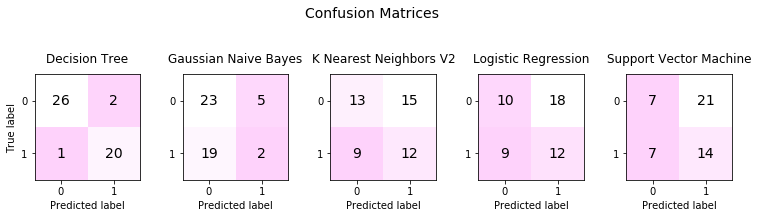

In [119]:
show_confusion_matrices(discrepancies_df, cols=classifier_labels)

The Gaussian Naive Bayes classifier failed to detect the majority of the malignant tumors in the subset of tumors for which there was a discrepancy between classifiers. 

In [120]:
get_performance_metrics_df(discrepancies_df, cols=classifier_labels).round(3)

,Recall,Accuracy,Precision,F1 Score
Classifier,,,,
Decision Tree,0.952,0.939,0.909,0.930
Support Vector Machine,0.667,0.429,0.400,0.500
K Nearest Neighbors V2,0.571,0.510,0.444,0.500
Logistic Regression,0.571,0.449,0.400,0.471
Gaussian Naive Bayes,0.095,0.510,0.286,0.143


In [121]:
discrepancies_df[(discrepancies_df["total_votes"] == 1) 
                 & (discrepancies_df["target"] == 1)][classifier_labels]

,Decision Tree,Gaussian Naive Bayes,K Nearest Neighbors V2,Logistic Regression,Support Vector Machine
202,0,0,0,1,0
211,1,0,0,0,0
216,1,0,0,0,0
236,1,0,0,0,0
256,1,0,0,0,0


Only the Decision Tree and the Logistic Regression classifiers correctly classified a positive sample all other classifiers classified as negative.

In [122]:
train_predictions_df[(train_predictions_df["Decision Tree"] == 0) 
                     & (train_predictions_df["target"] == 1)]

,target,Decision Tree,Gaussian Naive Bayes,K Nearest Neighbors,Logistic Regression,Support Vector Machine,K Nearest Neighbors V2,total_votes
187,1,0,0,0,0,0,0,0
202,1,0,0,1,1,0,0,1
327,1,0,0,0,0,0,0,0


Only the Logistic Regression Classifier (and the non-adjusted version of the K Nearest Neighbors classifier) correctly identified a positive sample that the Decision Tree Classifier failed to identify.

In [123]:
train_predictions_df[(train_predictions_df["Logistic Regression"] == 0) 
                     & (train_predictions_df["target"] == 1)]

,target,Decision Tree,Gaussian Naive Bayes,K Nearest Neighbors,Logistic Regression,Support Vector Machine,K Nearest Neighbors V2,total_votes
144,1,1,0,0,0,1,0,2
187,1,0,0,0,0,0,0,0
211,1,1,0,0,0,0,0,1
216,1,1,0,0,0,0,0,1
236,1,1,0,0,0,0,0,1
256,1,1,0,0,0,0,0,1
265,1,1,0,1,0,1,1,3
327,1,0,0,0,0,0,0,0
334,1,1,0,1,0,0,1,2
372,1,1,1,1,0,1,1,4


All of the other classifiers correctly identified a positive sample that the Logistic Regression Classifier failed to identify.

## Implement Voting on Training Set

It makes more sense to think of each classifier's prediction as red flag, rather than as a vote. While we may not care if 1 out of 5 dentists believes Crest makes the best toothpaste, we certainly care if 1 out of 5 oncologists believes a tumor is malignant.

In [124]:
train_predictions_df["1+ Votes"] = train_predictions_df[
    "total_votes"].apply(lambda x: 1 if x >= 1 else 0)

In [125]:
train_predictions_df["2+ Votes"] = train_predictions_df[
    "total_votes"].apply(lambda x: 1 if x >= 2 else 0)

In [126]:
train_predictions_df["Majority Vote"] = train_predictions_df[
    "total_votes"].apply(lambda x: 1 if x >= 3 else 0)

In [127]:
train_predictions_df["DT_LR"] = train_predictions_df[
    ["Decision Tree", "Logistic Regression"]].sum(axis=1)
train_predictions_df["DT_LR"] = train_predictions_df["DT_LR"].apply(
    lambda x: 1 if x > 0 else 0)

In [128]:
ensemble_classifier_labels = ["1+ Votes", "2+ Votes", "Majority Vote", "DT_LR"]

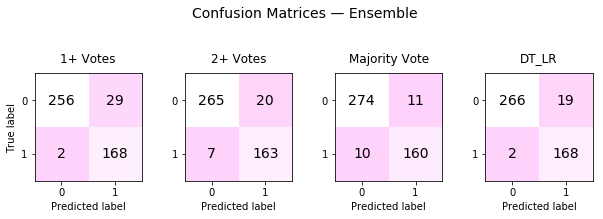

In [129]:
show_confusion_matrices(train_predictions_df, cols=ensemble_classifier_labels, 
                        title_info="Ensemble")

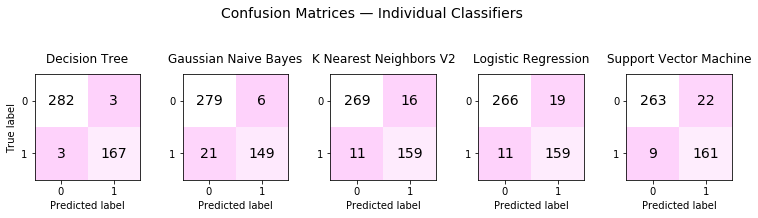

In [130]:
show_confusion_matrices(train_predictions_df, cols=classifier_labels, 
                        title_info="Individual Classifiers")

In [131]:
all_classifiers = ensemble_classifier_labels + classifier_labels

In [132]:
get_performance_metrics_df(train_predictions_df, cols=all_classifiers).round(3)

,Recall,Accuracy,Precision,F1 Score
Classifier,,,,
1+ Votes,0.988,0.932,0.853,0.916
DT_LR,0.988,0.954,0.898,0.941
Decision Tree,0.982,0.987,0.982,0.982
2+ Votes,0.959,0.941,0.891,0.924
Support Vector Machine,0.947,0.932,0.880,0.912
Majority Vote,0.941,0.954,0.936,0.938
K Nearest Neighbors V2,0.935,0.941,0.909,0.922
Logistic Regression,0.935,0.934,0.893,0.914
Gaussian Naive Bayes,0.876,0.941,0.961,0.917


** DT_LR had the same recall as 1+ Votes, and it also had higher accuracy. Thus, use DT_LR as the ultimate predictor for the test set.**

<hr>

<a id="Test_Set_Performance"></a>

# Performance on Test Set

## Get Test Set Predictions

In [133]:
test_predictions_df = get_test_set_predictions_df(
    classifiers_list, wbc_X_train, wbc_y_train, wbc_X_test, wbc_y_test)

In [134]:
test_predictions_df.head()

,target,Decision Tree,Gaussian Naive Bayes,K Nearest Neighbors,Logistic Regression,Support Vector Machine
0,1,1,1,1,1,1
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,1,1,1,1,1,1
4,0,0,0,0,0,0


## Implement Voting on Test Set

**Get ensemble classifier predictions:**

- Include all classifiers included for comparison
- If predictions were not already in a dataframe for display purposes (i.e. in a numpy array instead), I would have created or imported a majority vote classifier object.

In [135]:
test_classifier_labels = ["Decision Tree", "Gaussian Naive Bayes", 
                          "K Nearest Neighbors", "Logistic Regression", 
                          "Support Vector Machine"]

In [136]:
test_predictions_df["total_votes"] = test_predictions_df[
    test_classifier_labels].sum(axis=1)

In [137]:
test_predictions_df["1+ Votes"] = test_predictions_df[
    "total_votes"].apply(lambda x: 1 if x >= 1 else 0)

In [138]:
test_predictions_df["2+ Votes"] = test_predictions_df[
    "total_votes"].apply(lambda x: 1 if x >= 2 else 0)

In [139]:
test_predictions_df["Majority Vote"] = test_predictions_df[
    "total_votes"].apply(lambda x: 1 if x >= 3 else 0)

In [140]:
test_predictions_df["DT_LR"] = test_predictions_df[
    ["Decision Tree", "Logistic Regression"]].sum(axis=1)
test_predictions_df["DT_LR"] = test_predictions_df["DT_LR"].apply(
    lambda x: 1 if x > 0 else 0)

## Confusion Matrices

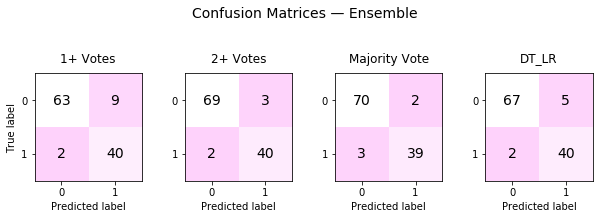

In [141]:
show_confusion_matrices(test_predictions_df, cols=ensemble_classifier_labels, 
                        title_info="Ensemble")

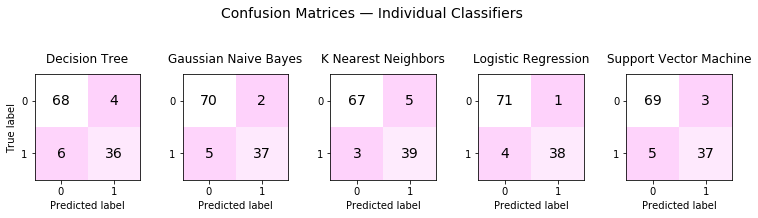

In [142]:
show_confusion_matrices(test_predictions_df, cols=test_classifier_labels, 
                        title_info="Individual Classifiers")

## Performance Metrics

In [143]:
get_performance_metrics_df(
    test_predictions_df, 
    cols=ensemble_classifier_labels+test_classifier_labels).round(3)

,Recall,Accuracy,Precision,F1 Score
Classifier,,,,
1+ Votes,0.952,0.904,0.816,0.879
2+ Votes,0.952,0.956,0.930,0.941
DT_LR,0.952,0.939,0.889,0.920
Majority Vote,0.929,0.956,0.951,0.940
K Nearest Neighbors,0.929,0.930,0.886,0.907
Logistic Regression,0.905,0.956,0.974,0.938
Gaussian Naive Bayes,0.881,0.939,0.949,0.914
Support Vector Machine,0.881,0.930,0.925,0.902
Decision Tree,0.857,0.912,0.900,0.878


Although recall was not as high as it was on the training data (0.988), it was still quite high at 0.952.